_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens, Dr. Alexander Ecker

Tutors: Sarah Strauss, Santiago Cadena

Summer term 2019

Due date: 2019-05-07, 9am

Student names: Boada, Ulzi, Peter

# Exercise sheet 3

Not every cluster in the fitted mixture model corresponds to a single neuron’s spikes (i.e. is a ‘single unit’). We will explore different ways of identifying single units and telling them apart from multi unit activity. In all your plots, color-code the clusters consistently. 

If needed, download the data file ```nda_ex_2_*.npy``` from ILIAS and save it in the subfolder ```../data/```. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.decomposition import PCA
from scipy.io import loadmat
import copy
import time

import warnings
warnings.filterwarnings("ignore")

sns.set_style('whitegrid')
%matplotlib inline

## Load data

In [2]:
%pwd

'C:\\Users\\ulzii\\JupyterNote\\SS19\\NeuralDataAnalysis\\HW3'

In [5]:
m = np.load('../data/nda_ex_2_means.npy')
S = np.load('../data/nda_ex_2_covs.npy')
a = np.load('../data/nda_ex_2_labels.npy')
# p_incorrect = np.load('data/nda_ex_2_pis.npy') # it's incorrectly saved
p = np.load('../data/nda_ex_2_pis.npy')


b = np.load('../data/nda_ex_1_features.npy')
t_rounded = np.load('../data/nda_ex_1_spiketimes_t.npy') # in miliseconds and rounded to the units
s = np.load('../data/nda_ex_1_spiketimes_s.npy') # in samples
w = np.load('../data/nda_ex_1_waveforms.npy')

In [6]:
N_ch = 4
N_cl = np.max(a)+1
Fs = 30000
dt = 1/Fs

# non-rounded spike times
t = s*dt*1000 

## Task 1: Visual inspection of clusters

The most obvious candidates for single units are clusters that you can identify visually as being well separated from the rest. You can use the plotting function you implemented last week (Exercise 2 Task 4) as a first tool to identify putative single units. Of course there may be other less obvious cases in the data.

*Grading: 0 pts*


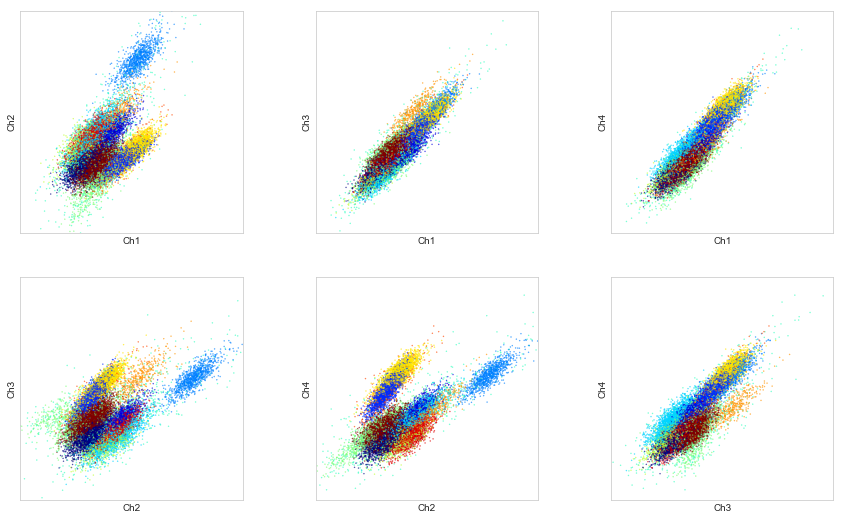

In [7]:
colors = plt.cm.jet(np.linspace(0,1,max(a)+1))

# plot
fig = plt.figure(figsize=(15, 9))

c = np.squeeze(colors[a])

idx = [0, 3, 6, 9]
pl = 1

labels = ['Ch1','Ch2','Ch3','Ch4']
for i in np.arange(0,4):
    for j in np.arange(i+1,4):
        ax = plt.subplot(2,3,pl, aspect='equal')
        ax.scatter(b[:,idx[i]], b[:,idx[j]], c=c, s=.7,marker='.',alpha=0.8)
        plt.xlabel(labels[i])
        plt.ylabel(labels[j])
        plt.xlim((-800,1300))
        plt.ylim((-800,1300))
        ax.set_xticks([])
        ax.set_yticks([])
        pl = pl+1

Visually, we identify 2 clusters which seem clearly distant from the rest: green and orange. We also see that yellow and dark blue are very close because they might be all spikes from the same neuron.

Not all clusters represent the spikes of a single neuron.
- Single unit: a cluster with one neuron's spikes.
- Multi unit: a cluster with multiple neuron's spikes.

3 situations:
    i. A neuron's spikes are clustered in a unique single unit cluster
    ii. A neuron's spikes are clustered in 2 or more single unit clusters.
    iii. 2 or more neuron's spikes are clustered in the same multi unit cluster
    ...

## Task 2: Visual inspection of waveforms

Plot the average waveforms and 100 examples from each cluster. This is a good sanity check and helps to identify potential artifacts such as electrical noise or clusters representing overlapping spikes (they often have large variance and few spikes). 

*Grading: 2 pts*


In [8]:
print('SHAPES:\n Waveform matrix, w: {}\n Assignment array, a: {}'.format(w.shape,a.shape))

SHAPES:
 Waveform matrix, w: (30, 20453, 4)
 Assignment array, a: (20453,)


In [9]:
def plotWaveforms(w, assignment, N_waveforms=20):
# Plot waveforms for each cluster.
#  plotWaveforms(w, assignment) plots for all four channels of each
#  cluster 100 sample waveforms, overlaid by the average waveform. All
#  panels are drawn on the same scale to facilitate comparison.

    # Build plot structure, titles, labels
    plt.subplots(N_cl,4, figsize=(15,20))
    plt.subplots_adjust(left=.125, bottom=.1, right=.9, top=1.5, wspace=.25, hspace=.3) 

    for i in range(N_cl*N_ch):

        titles = np.array([0, 1, 2, 3])
        if (i==titles).any():
            plt.subplot(N_cl,4,i+1)
            plt.title('Ch {}'.format(i+1))

        xlabels = np.array([48, 49, 50, 51])
        if (i==xlabels).any():
            plt.subplot(N_cl,4,i+1)
            plt.xlabel('Time (ms)')

        ylabels = np.arange(0,49,4)
        clusters = np.arange(1,15,1)
        if (i==ylabels).any():
            plt.subplot(N_cl,4,i+1)
            plt.ylabel('CLUSTER {}\n Voltage (mV)'.format(int(np.array(np.where((ylabels==i)))+1)))

        plt.subplot(N_cl,4,i+1)
        plt.ylim((-800,400))

    # Plot        
    t_array = np.arange(0,30,1)/Fs*1000
    for cl in range(N_cl):

        # Select all spikes from a cluster cl
        idx_spikes_cl = np.array(np.where(assignment==cl)).squeeze()
        # Choose N_waveforms from those randomly
        idx_spikes_cl = np.random.choice(idx_spikes_cl, N_waveforms)

        for ch in range(N_ch):
            plt.subplot(N_cl,4, ch+1 + cl*4)
            plt.plot(t_array, w[:,idx_spikes_cl,ch], c=colors[cl])
            avg = np.mean(w[:,idx_spikes_cl,ch], axis=1)
            plt.plot(t_array,avg, 'k')

    plt.show()

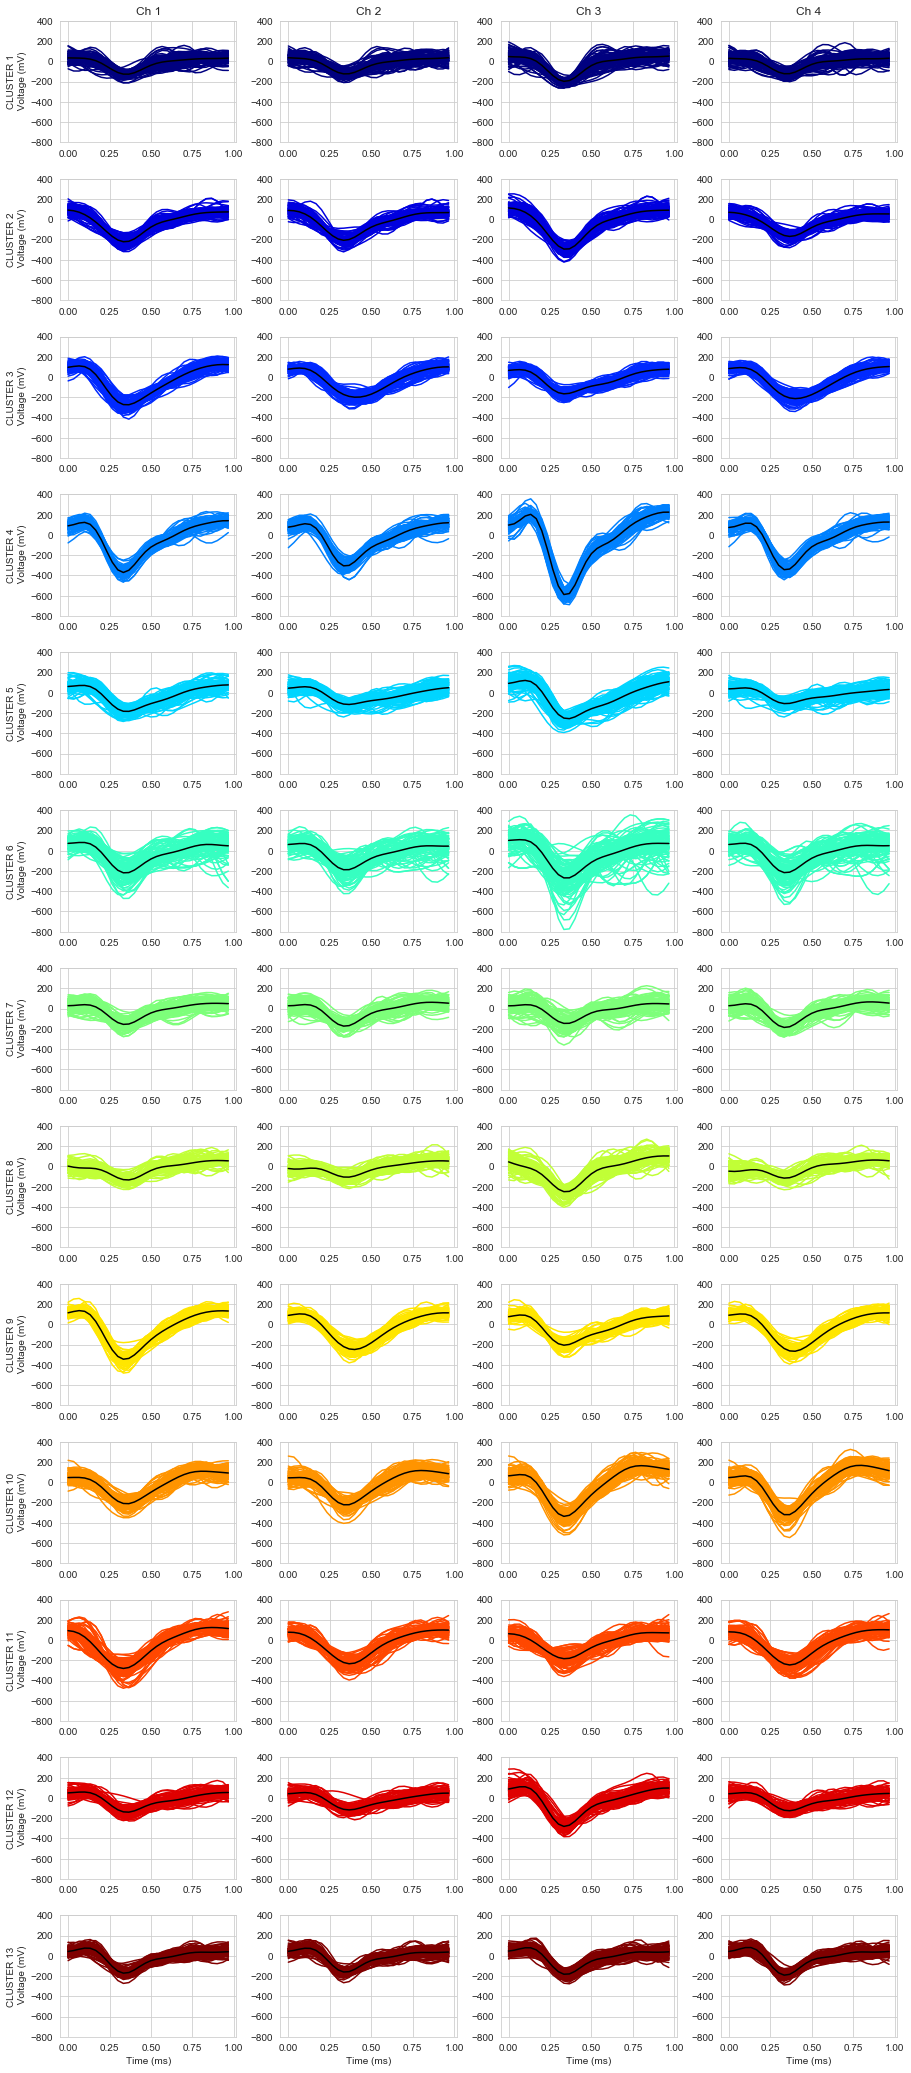

In [10]:
plotWaveforms(w,a,N_waveforms=100)

## Task 3: Auto/cross-correlation
Implement a function to calculate the auto/cross-correlograms of all clusters/pairs of clusters called `correlogram()`. Correlograms are useful mostly for two reasons:

* To identify clusters that represent multi unit activity. Neurons have a refractory period: after firing a spike they cannot fire another spike within a period of time (at least 1 ms, often more, depending on the cell type). Thus, if multiple cells contribute to one cluster, it won’t have a refractory period. 
* To identify two (or more) clusters that represent the same single unit: if this is the case the cross-correlogram of the two clusters should show the refractory period, since it consists of spikes from only one cell, which cannot occur too close to each other. 

Plot a matrix with cross- and auto-correlograms like shown in the lecture. Use a bin size of 0.5 ms and a range of ±20 ms. Which auto-correlograms show a refractory period? Which cross-correlograms do?   

You need to take some care to ensure that the implementation of the crosscorrelogram function is efficient, otherwise this may take a while.


*Grading: 4 pts*



## Cross Correlogram
This link explained really well how to compute [Cross Correlogram](https://www.med.upenn.edu/mulab/crosscorrelation.html)

In [11]:
def correlogram(t, assignment, binsize, maxlag):
# Calculate cross correlogram
#   ccg = correlogram(t, assignment, binsize, maxlag) calculates the 
#   cross- and autocorrelograms for all pairs of clusters with input
#       t               spike times             #spikes x 1
#       assignment      cluster assignments     #spikes x 1
#       binsize         bin size in ccg         scalar
#       maxlag          maximal lag             scalar
# 
#    and output
#       ccg             computed correlograms   #bins x #clusters x #clusters
#       bins            bin times relative to center    #bins x 1
    

 
    N_bins = int(2*maxlag/binsize)

    ccg = np.zeros((N_bins,N_cl,N_cl))
    # Smart way picking the same pair only once
    for ref in range(N_cl):
        for target in range(ref,N_cl):
            # Select spike times from the pair of clusters
            refSpikes = t[assignment==ref]
            targetSpikes = t[assignment==target]

            # for each reference spike time, we check if the lag is within a range of +/- maxlag
            for i in range(len(refSpikes)):
                # Given a spike time from the reference cluster: 
                # we calculate the time difference from all spikes in the target cluster to that given spike 
                # we then check if there are spikes in target cluster happening in a +/- 20ms range
                # we then retrieve only the target spikes such that referenceSpikeTime - 20 < targetSpike < referenceSpikeTime + 20
                in_rangeSpikes = (targetSpikes-refSpikes[i])[abs(targetSpikes-refSpikes[i]) < maxlag] 
                                
                # Match each time difference with a bin
                bin_matches = np.floor((in_rangeSpikes+maxlag)/binsize).astype(int)
                # Allocate each one in its corresponding bin for the histogram. There are 81 bins, from -20 to +20ms in 0.5ms steps
                bin_count = np.bincount(bin_matches, minlength=N_bins)
                # Add those counts to the total count in ccg
                ccg[:,ref,target] += bin_count
                # Fill in also the other lower part of ccg, which is symmetric to the upper part.  
                # and according to the cross correlogram reference, we just need to flip them
                if ref != target:
                        ccg[:, target, ref] += np.flipud(bin_count)

            # Correct the center value for the diagonal correlograms: Each spike counts +1 at 0 because it are compared with itself,
            # so to get a nice correlogram in which we can see differences between the spikes in the same cluster, we subtract the
            # number of spikes that the cluster has from the center bar at 0.            
            if ref == target:
                    ccg[int(N_bins/2), ref, ref] -= np.shape(refSpikes)[0]

    bins = np.arange(-maxlag+binsize/2, maxlag+binsize/2, binsize) # +binsize/2 to be centered at 0
        
    return (ccg, bins)

In [12]:
def plotCCG(ccg, bins, figure=2, axis='off'):
#Plot cross-correlograms of all pairs.
#   plotCCG(ccg,bins) plots a matrix of cross(auto)-correlograms for
#   all pairs of clusters. Inputs are:
#       ccg     array of cross correlograms           #bins x #clusters x #clusters
#       bins    array with bin timings                #nbins x 0
    
    colors = plt.cm.jet(np.linspace(0,1,ccg.shape[1]+1))
    
    # plot
    fig = plt.figure(figure, figsize=(12, 10))
    plt.clf

    bg = 0.7*np.ones(3)
    
    N_cl = ccg.shape[1] 
    
    for ix in range(N_cl):
        for jx in range(N_cl):
            ax = plt.subplot(N_cl,N_cl,N_cl*ix+jx+1, facecolor=bg)
            
            if ix == jx:
                ax.bar(bins, ccg[:, ix, jx], width=1, facecolor=colors[ix, :], edgecolor=colors[ix, :])
            else:
                ax.bar(bins, ccg[:, ix, jx], width=1, facecolor='k', edgecolor='k')
            ax.axis(axis)
            ax.set_xlim(1.2 * bins[[0,-1]])
            ylim = np.array(list(ax.get_ylim()))
            ax.set_ylim(np.array([0, 1.2]) * ylim)
            ax.set_yticks([])

            if ix != jx:
                ax.plot(0, 0, '*', c=colors[jx, :])
                
            if ix != N_cl-1:
                ax.set_xticks([])
                
            if ix == N_cl-1:
                ax.set_xlabel('ms')


In [13]:
(ccg, bins) = correlogram(t, a, binsize=.5, maxlag=20)

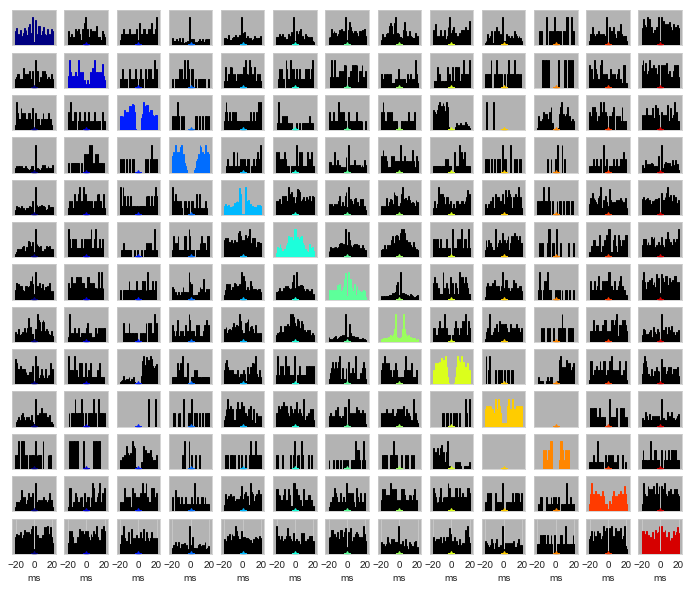

In [14]:
plotCCG(ccg,bins,axis='on')

### Task 4: Cluster separation
Implement linear discriminant analysis to visualize how well each cluster is separated from its neighbors in the high-dimensional space in the function `separation()`. Project the spikes of each pair of clusters onto the axis that optimally separates those two clusters. 

Plot a matrix with pairwise separation plots, showing the histogram of the points in both clusters projected on the axis best separating the clusters (as shown in the lecture). *Hint:* Since Python 3.5+, matrix multiplications can be compactely written as `x@y`.


*Grading: 4 pts*


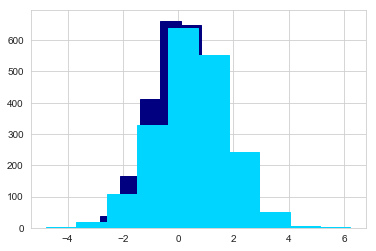

In [16]:
# Select a pair of clusters
ix = 0
jx = 4

# Take the features of all spikes in that pair of clusters
bA = b[a==ix]
bB = b[a==jx]

# Calculate within-class scatter matrix
S_within = S[:,:,ix] + S[:,:,jx]

# Calculate Between-class scatter matrix 
m_total = (m[ix]+m[jx])/2
S_between = len(bA)*(m[ix]-m_total).reshape(12,1)@((m[ix]-m_total)[np.newaxis]) +\
            len(bB)*(m[jx]-m_total).reshape(12,1)@((m[jx]-m_total)[np.newaxis])  # just to write in the next line


# Solving the generalized eigenvalue problem for the matrix  np.inv(SW)*SB
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_within).dot(S_between))
    
# Take the eigenvector with highest eigenvalue
axis_LDA = eig_vecs[np.argmax(eig_vals)]

# Project all the data to that axis_LDA
W = axis_LDA.reshape(12,1) # projection matrix
qi = (bA@W).real
qj = (bB@W).real

# normalization so that we can plot everything at the same scale.
# The result is normalized such that the left (i.e. first) cluster has zero mean and unit variances.
m_norm = np.mean(qi)
sd_norm = np.std(qi)
qi = (qi - m_norm) / sd_norm
qj = (qj - m_norm) / sd_norm


plt.hist(qi, facecolor=colors[ix], edgecolor=colors[ix])
plt.hist(qj, facecolor=colors[jx], edgecolor=colors[jx])
plt.show()

In [17]:
def separation(b, m, S, p, assignment, nbins=50, figure=3):
# Calculate cluster separation
#   proj, bins = separation(b, m, S, p, assignment) 
#   projects the data on the LDA axis for all pairs of clusters. The result
#   is normalized such that the left (i.e. first) cluster has 
#   zero mean and unit variances. The LDA axis is estimated from the model.
#   
#       b               features             #spikes x #features
#       m               mean                 #clusters x #features
#       S               covariances          #features x # features x #clusters
#       p               priors               #clusters x 1
#       assignment      cluster assignments     #spikes x 1
# 
#  and output
#       proj            computed lda histograms   #bins x #clusters x
#                                                               #clusters
#       bins            bin times relative to center    #bins x 1



    N_cl = np.max(assignment)+1 # Ncl
    colors = plt.cm.jet(np.linspace(0,1,N_cl))
        
    fig = plt.figure(figure, figsize=(12, 12))
    plt.clf

    bg = 0.7*np.ones(3)
    
    proj = np.zeros((nbins-1,N_cl,N_cl))
    for ix in range(N_cl):
        for jx in np.delete(np.arange(0,N_cl), ix):

            # fill in your code here
            # Take the features of all spikes in that pair of clusters
            bA = b[a==ix]
            bB = b[a==jx]

            # Calculate within-class scatter matrix
            S_within = S[:,:,ix] + S[:,:,jx]

            # Calculate Between-class scatter matrix 
            m_total = (m[ix]+m[jx])/2
            S_between = len(bA)*(m[ix]-m_total).reshape(12,1)@((m[ix]-m_total)[np.newaxis]) +\
                        len(bB)*(m[jx]-m_total).reshape(12,1)@((m[jx]-m_total)[np.newaxis])  # just to write in the next line


            # Solving the generalized eigenvalue problem for the matrix  np.inv(SW)*SB
            eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_within).dot(S_between))

            # Take the eigenvector with highest eigenvalue
            axis_LDA = eig_vecs[np.argmax(eig_vals)]

            # Project all the data to that axis_LDA
            W = axis_LDA.reshape(12,1) # projection matrix
            qi = (bA@W).real
            qj = (bB@W).real

            # normalization so that we can plot everything at the same scale.
            # The result is normalized such that the left (i.e. first) cluster has zero mean and unit variances.
            m_norm = np.mean(qi)
            sd_norm = np.std(qi)
            qi = (qi - m_norm) / sd_norm
            qj = (qj - m_norm) / sd_norm
            
            

            # plot histograms on optimal axis
            
            ax = plt.subplot(N_cl,N_cl,ix*N_cl+jx+1, facecolor=bg)
            bins = np.linspace(-3, 10, nbins)
            h = np.array([np.histogram(qi, bins)[0], np.histogram(qj, bins)[0]])
            
            # What should we exactly save in "proj"? I just summed the the hist of both cluster (but then we dont save what comes from where)
            proj[:,ix,jx] = h[0] + h[1]
            if ix!=jx: proj[:,jx,ix] = proj[:,ix,jx]
            
            ax.bar(bins[1:-1], h[0,1:], 1, facecolor=colors[ix], edgecolor=colors[ix], linestyle=None)
            ax.bar(bins[1:-1], h[1,1:], 1, facecolor=colors[jx], edgecolor=colors[jx])
                        
            ax.set_ylim([0, 1.2 * np.max(h[0, :])])
            ax.set_xlim([-3, 10])
            ax.set_yticks([])
            ax.set_xticks([])
            
    return proj, bins

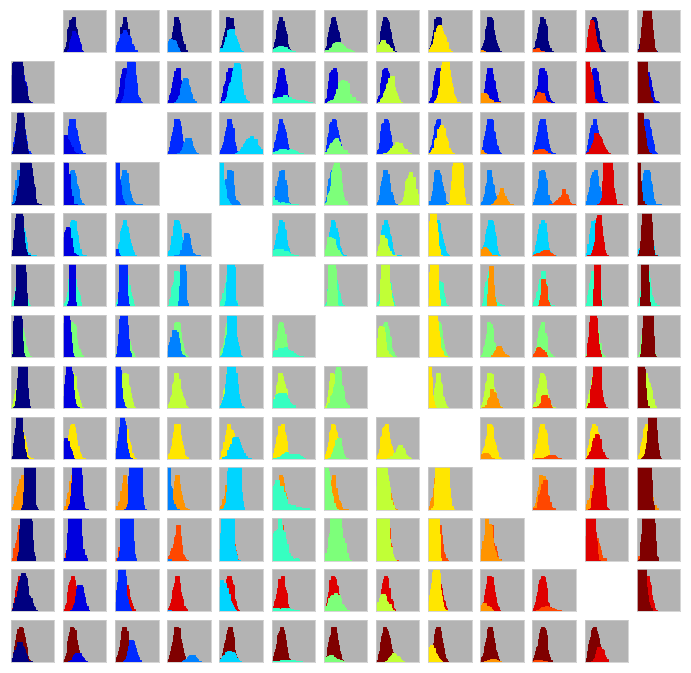

In [18]:
proj, bins = separation(b, m, S, p, a, nbins=50)

We ran 2 different versions of the LDA algorithm. The variability was so high that it would change depending on how we ran it. If we use the eigenvalues, we get a different result than if we use the proportionality from the Bishop book

According to Bishop's Machine Learning: 

$ w \propto S^{-1}_W(m_2 - m_1) $ 

and 

$ y = w^Tx $

In [21]:
def separation(b, m, S, p, assignment, nbins=50, figure=3):
# Calculate cluster separation
#   proj, bins = separation(b, m, S, p, assignment) 
#   projects the data on the LDA axis for all pairs of clusters. The result
#   is normalized such that the left (i.e. first) cluster has 
#   zero mean and unit variances. The LDA axis is estimated from the model.
#   
#       b               features             #spikes x #features
#       m               mean                 #clusters x #features
#       S               covariances          #features x # features x #clusters
#       p               priors               #clusters x 1
#       assignment      cluster assignments     #spikes x 1
# 
#  and output
#       proj            computed lda histograms   #bins x #clusters x #clusters
#       bins            bin times relative to center    #bins x 1
   
    K = np.max(assignment)+1
    colors = plt.cm.jet(np.linspace(0,1,K))
        
    fig = plt.figure(figure, figsize=(12, 12))
    plt.clf

    bg = 0.7*np.ones(3)
    
    for ix in range(K):
        for jx in np.delete(np.arange(0,K), ix):

            # fill in your code here 
            S_within_class = S[:, :, ix]+S[:,:, jx]
            w = (np.linalg.inv(S_within_class)@(m[jx, :] - m[ix, :]))
            
            # Retrieve x1 and x2
            xi, xj = b[assignment == ix, :], b[assignment == jx, :] 
            
            # y_pred = w*x1 
            yi, yj = xi@w, xj@w 
            
            # Now to standardize our predictions (by the first cluster for both) and store them in qi and qj 
            yi_mean, yi_std = np.mean(yi), np.std(yi)
            qi, qj = (yi-yi_mean)/yi_std,  (yj-yi_mean)/yi_std 
            
            # plot histograms on optimal axis
            ax = plt.subplot(K,K,ix*K+jx+1, facecolor=bg)
            bins = np.linspace(-3, 10, nbins)
            h = np.array([np.histogram(qi, bins)[0], np.histogram(qj, bins)[0]]) #I switched them up, made sense for qi to be the first
            ax.bar(bins[1:-1], h[0,1:], 1, color=colors[jx], edgecolor=colors[jx], linestyle=None)
            ax.bar(bins[1:-1], h[1,1:], 1, color=colors[ix], edgecolor=colors[ix])
                        
            ax.set_ylim([0, 1.2 * np.max(h[0, :])])
            ax.set_xlim([-3, 10])
            ax.set_yticks([])
            ax.set_xticks([])
            

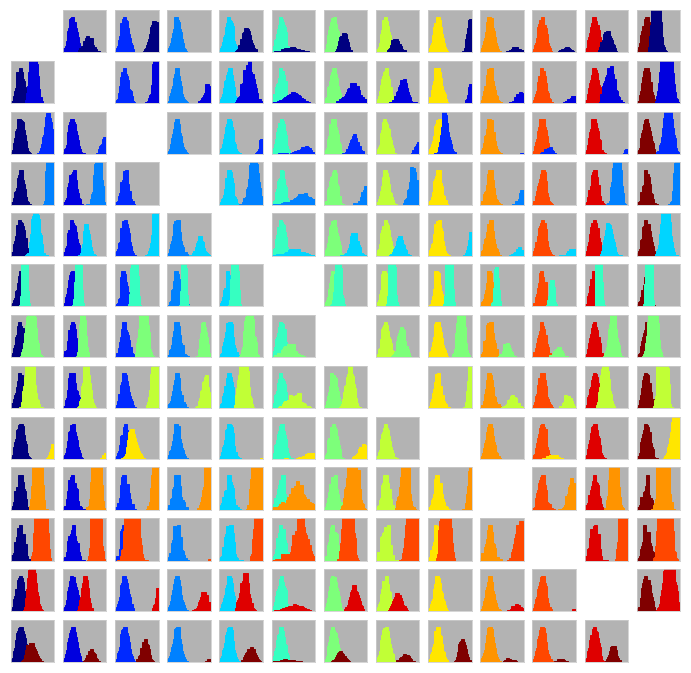

In [22]:
separation(b,m,S,p,a)

## Task 5: Identify putative single units. 

Use all of the above tools to identify all putative single units in the dataset. Which ones are these and why?

From the Correlogram we can see that 2, 3, 8, 10 shows single unit activity. Also, correlogram shows 2 and 3 could be single unit activity. So there could be 3 single units.